In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle

from utils import *

### Train on Goose_2nd_2

In [4]:
val_dates = ['180413']
test_dates = ['180414']

train_loader, val_loader, test_loader = create_dataloaders(val_dates=val_dates, test_dates=test_dates, batch_size=128, version='_Goose_2nd_2', upsample=True)

In [5]:
len(train_loader), len(val_loader), len(test_loader)

(148, 28, 22)

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim=100*10*62, output_dim=1):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, 256)
        self.linear2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = x.reshape([x.shape[0], 1, -1]).float()
        x1 = F.relu(self.linear1(x))
        outputs = self.linear2(x1)
        return outputs

In [9]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'MLP'
loss_type = 'bce'
reg_type = 'none'
CH = 'all'

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# optimizer = torch.optim.LBFGS(model.parameters(), lr = learning_rate)

In [10]:
epochs, training_losses, training_acc, val_losses, validation_acc = [], [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, train_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Train loss for epoch {}: {}'.format(epoch, train_loss))
    val_loss, val_acc = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_2nd_2_upsample'
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, epoch))

Train loss for epoch 0: 7.583985328674316
Val loss for epoch 0: 6.248083591461182
0
Train loss for epoch 1: 3.197084665298462
Val loss for epoch 1: 5.204477787017822
1
Train loss for epoch 2: 1.7028555870056152
Val loss for epoch 2: 4.288487911224365
2
Train loss for epoch 3: 0.4517427384853363
Val loss for epoch 3: 3.799541711807251
3
Train loss for epoch 4: 0.3622758984565735
Val loss for epoch 4: 4.769021987915039
Train loss for epoch 5: 0.3717140555381775
Val loss for epoch 5: 5.709033489227295
Train loss for epoch 6: 0.3854968845844269
Val loss for epoch 6: 4.161175727844238
Train loss for epoch 7: 0.3253587484359741
Val loss for epoch 7: 6.478695392608643
Train loss for epoch 8: 0.3182675838470459
Val loss for epoch 8: 7.306471824645996
Train loss for epoch 9: 0.3099137544631958
Val loss for epoch 9: 6.244534492492676
Train loss for epoch 10: 0.3090904653072357
Val loss for epoch 10: 6.142233848571777
Train loss for epoch 11: 0.30906277894973755
Val loss for epoch 11: 6.214609622

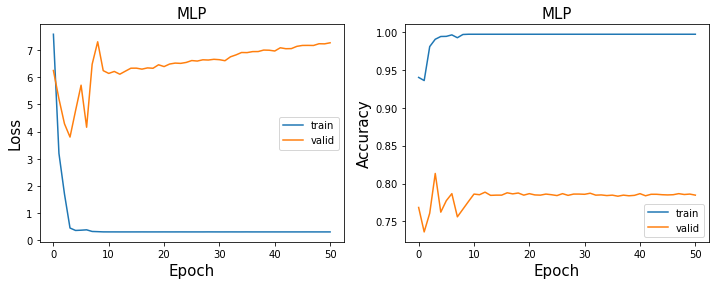

In [11]:
plot_loss_acc(training_losses, val_losses, training_acc, validation_acc, model_type)

In [12]:
model = MLP().to(device)
path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_2nd_2_upsample'
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, best_epoch)))

<All keys matched successfully>

In [13]:
test_loss, test_acc, test_preds, test_preds_probs, test_labels, cases_wrong_0 = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('test loss:{} accuracy:{}'.format(test_loss, test_acc))

test loss:0.6607409715652466 accuracy:0.9649057997783524


In [ ]:
np.mean(np.concatenate(test_labels))

In [24]:
0.5*0.9649057997783524 + 0.5*0.9359897583613378

0.9504477790698451

In [25]:
0.33*0.9649057997783524 + 0.67*0.9359897583613378

0.9455320520289527

In [23]:
np.mean(np.concatenate(test_labels))

0.7750277

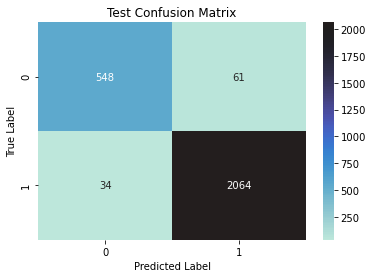

In [14]:
predictions_test = np.concatenate(test_preds)
labels_test = np.concatenate(test_labels)

df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

cm_test = confusion_matrix(labels_test, predictions_test)
ax = plt.axes()
sn.heatmap(cm_test, annot = True, fmt = "d", ax = ax, center=2000)
ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

### Train on Goose_1st_2 and Goose_2nd_2

In [35]:
val_dates = ['180328','180329','180413']
test_dates = ['180330','180331','180414']
version = '_Goose_all_2'

train_loader, val_loader, test_loader = create_dataloaders(val_dates=val_dates, test_dates=test_dates, batch_size=128, version=version, upsample=True)

In [36]:
len(train_loader), len(val_loader), len(test_loader)

(397, 49, 70)

In [37]:
class MLP(nn.Module):
    def __init__(self, input_dim=100*10*62, output_dim=1):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, 256)
        self.linear2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = x.reshape([x.shape[0], 1, -1]).float()
        x1 = F.relu(self.linear1(x))
        outputs = self.linear2(x1)
        return outputs

In [38]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'MLP'
loss_type = 'bce'
reg_type = 'none'
CH = 'all'

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [31]:
epochs, training_losses, training_acc, val_losses, validation_acc = [], [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, train_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Train loss for epoch {}: {}'.format(epoch, train_loss))
    val_loss, val_acc = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_all_2_upsample'
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, epoch))

Train loss for epoch 0: 2.844045400619507
Val loss for epoch 0: 0.33431488275527954
0
Train loss for epoch 1: 0.133906289935112
Val loss for epoch 1: 0.34499409794807434
Train loss for epoch 2: 0.07562623918056488
Val loss for epoch 2: 0.3541613221168518
Train loss for epoch 3: 0.07212857156991959
Val loss for epoch 3: 0.4004025161266327
Train loss for epoch 4: 0.08602574467658997
Val loss for epoch 4: 0.492890864610672
Train loss for epoch 5: 0.07495506852865219
Val loss for epoch 5: 0.6031906008720398
Train loss for epoch 6: 0.07682202011346817
Val loss for epoch 6: 0.7121862173080444
Train loss for epoch 7: 0.07915868610143661
Val loss for epoch 7: 1.4556916952133179
Train loss for epoch 8: 0.10367901623249054
Val loss for epoch 8: 0.8133669495582581
Train loss for epoch 9: 0.05752880871295929
Val loss for epoch 9: 0.9600936770439148
Train loss for epoch 10: 0.09688373655080795
Val loss for epoch 10: 1.2716152667999268
Train loss for epoch 11: 0.11892979592084885
Val loss for epoch 

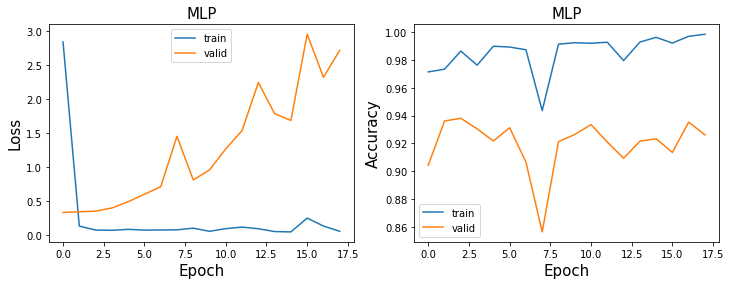

In [32]:
plot_loss_acc(training_losses, val_losses, training_acc, validation_acc, model_type) # 17 epochs

In [39]:
model = MLP().to(device)
path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_all_2_upsample'
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, best_epoch)))

<All keys matched successfully>

In [40]:
test_loss, test_acc, test_preds, test_preds_probs, test_labels, cases_wrong_0 = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('test loss:{} accuracy:{}'.format(test_loss, test_acc))

test loss:0.2511501908302307 accuracy:0.9359088878963823


In [41]:
np.mean(np.concatenate(test_labels))

0.7495534

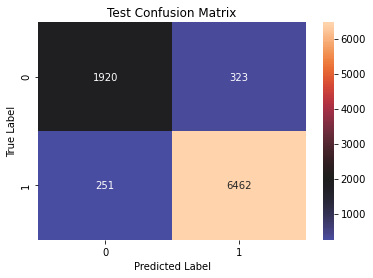

In [42]:
predictions_test = np.concatenate(test_preds)
labels_test = np.concatenate(test_labels)

df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

cm_test = confusion_matrix(labels_test, predictions_test)
ax = plt.axes()
sn.heatmap(cm_test, annot = True, fmt = "d", ax = ax, center=2000)
ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()